**1. Stress testing** - continue the range of the input data to include “extreme” values. This will extend partial dependence. 
- Looking to automate this for the top n features using the API
- Sent Matt Ben’s notebook and Ofer’s pictures.
- Ben and Ofer script could be improved by:
 - Parameterizing the inputs 
 - Identifying the original CV records in the original model
 - A more automated way of identifying the blueprint used in the original project.

In [1]:
import pandas as pd
import numpy as np
import datarobot as dr
import scipy.stats as st
import random
import time
import warnings
warnings.filterwarnings('ignore')
import re
import os
import stress_test

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_path = 'data/'
df = pd.read_csv(data_path + '10K_Lending_Club_Loans.csv', encoding = "ISO-8859-1")
#df = df.sample(500)
TARGET_NAME = 'is_bad'

In [3]:
dr.Client(token=os.environ['DATAROBOT_API_TOKEN'], endpoint='https://app.datarobot.com/api/v2')
PROJECT_ID = '5ac44503c92d810016538e5e'
MODEL_ID = '5ac448e3adb29ab27bc60168'

In [4]:
# Get the cross validation folds from the original project run
data_cvfs = stress_test.get_training_predictions(PROJECT_ID, MODEL_ID)
print(data_cvfs.partition_id.value_counts())
data_cvfs[:10]

Training predictions are already requested and are ready.
- Time: 'get_training_predictions' 4.64
Holdout    2000
2.0        1600
0.0        1600
1.0        1600
3.0        1600
4.0        1600
Name: partition_id, dtype: int64


,row_id,partition_id,prediction,class_1.0,class_0.0
0,0,1.0,0.0,0.022636,0.977364
1,1,Holdout,0.0,0.321055,0.678945
2,2,Holdout,0.0,0.087278,0.912722
3,3,4.0,0.0,0.099623,0.900377
4,4,2.0,0.0,0.036142,0.963858
5,5,Holdout,0.0,0.186051,0.813949
6,6,Holdout,0.0,0.016583,0.983417
7,7,4.0,0.0,0.230907,0.769093
8,8,0.0,0.0,0.130532,0.869468
9,9,0.0,0.0,0.208504,0.791496


In [5]:
# Get the top n features for the model
top_features = stress_test.get_model_top_features(PROJECT_ID, MODEL_ID, 10)
print(top_features)
df[top_features].info()

Model type: AVG Blender
Requesting feture impact for model 5ac448e3adb29ab27bc60168
Feature impact compute done.
- Time: 'get_model_top_features' 3.80
['desc', 'annual_inc', 'int_rate', 'title', 'inq_last_6mths', 'term', 'revol_util', 'open_acc', 'grade', 'dti']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
desc              6833 non-null object
annual_inc        9999 non-null float64
int_rate          10000 non-null object
title             9996 non-null object
inq_last_6mths    9995 non-null float64
term              10000 non-null object
revol_util        9977 non-null float64
open_acc          9995 non-null float64
grade             10000 non-null object
dti               10000 non-null float64
dtypes: float64(5), object(5)
memory usage: 781.3+ KB


In [6]:
# Previous approach of fitting a KernelDensity with GridSearch over bandwidth, 
# and then getting the pdf from the data for it.
#stress_test.sample_low_proba_univariate_values(df.annual_inc, .05)

# --------------
# Dev
# --------------

In [7]:
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        print('- Time: %r %0.2f' % (method.__name__, (te - ts)))
        return result
    return timed

In [8]:
d = {
    'int_rate': ['5.00%', '10.00%', '15.00%', '20.00%'],
    'annual_inc': [10000.00, 100000.00, 150000.00, 200000.00]
}
# 'grade': ['A', 'B', 'C', 'D', 'E', 'F', 'G']
# 'loan_amt': [1000,10000,100000,1000000]
# 'int_rate': ['5.00%', '10.00%', '15.00%', '20.00%']

In [9]:
def do_stress_test(project_id, model_id, features):
    '''
    Stress test the model with fixed feature values.  Essentially, specific partial dependency calculations.
    
    Parameters:
        project id
        model id
        features - dict of feature names and values to test
        
    Returns:
        DataFrame of 3 columns,
            - feature name
            - feature value
            - y^ prediction
    '''
    project = dr.Project(id=project_id)
    model = dr.Model.get(project=project_id, model_id=model_id)
    
    k_v_avg_pred = []
    # loop through all features and values for stress testing
    for feature_name in features:
        for feature_value in features[feature_name]:
            # get selected model
            model = dr.Model.get(project=PROJECT_ID, model_id=model_id)
            # reset dataset
            sample = df.sample(n=1000)
            data = sample.copy()
            data[feature_name] = feature_value
            # upload as stress_data
            stress_data = project.upload_dataset(data)
            # start a predict job
            predict_job = model.request_predictions(stress_data.id)
            # get job status every 5 seconds and move on once 'inprogress'
            for i in range(100):
                time.sleep(5)
                try:
                    job_status = dr.PredictJob.get(
                        project_id=PROJECT_ID, 
                        predict_job_id=predict_job.id
                    ).status
                except:  # normally the job_status would produce an error when it is completed
                    print(feature_name, feature_value, 'predictions finished')
                    break
            # now the predictions are finished
            predictions = dr.PredictJob.get_predictions(
                project_id=PROJECT_ID,
                predict_job_id=predict_job.id
            )
            k_v_avg_pred.append((feature_name, feature_value, predictions.positive_probability.mean()))
    
    return pd.DataFrame(k_v_avg_pred, columns=['feature', 'x', 'y'])

Model type: AVG Blender
Requesting feture impact for model 5ac448e3adb29ab27bc60168
Feature impact compute done.
- Time: 'get_top_n_features' 3.63
Model type: AVG Blender
Requesting feture impact for model 5ac448e3adb29ab27bc60168
Feature impact compute done.
- Time: 'get_top_n_features' 4.37
grid best params: {'bandwidth': 0.22413793103448276}
samples: [1.9854655335391902, -3.1710142271954718]
- Time: 'sample_low_proba_univariate_values' 8.11
annual_inc -3.1710142271954718 predictions finished
annual_inc 1.9854655335391902 predictions finished


,feature,x,y
0,annual_inc,-3.171014,0.185946
1,annual_inc,1.985466,0.183093


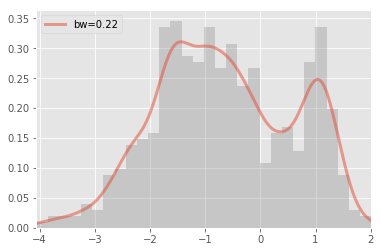

In [10]:
#import pdb; pdb.set_trace()

# Get model top features
# ensure only numericals?
top_features = stress_test.get_top_n_features(PROJECT_ID, MODEL_ID, 10)
stress_test.get_top_n_features(PROJECT_ID, MODEL_ID, 10)
features = top_features

# auto determine distribution

# auto determnine extreme values
x = df.annual_inc
from scipy.stats.distributions import norm
x = np.concatenate([norm(-1, 1.).rvs(400),
                    norm(1, 0.3).rvs(100)])
features_extreme_vals = stress_test.sample_low_proba_univariate_values(x, .05)

# perform stress test with given feature variables and extreme values
feature_dict = {}
feature_dict['annual_inc'] = features_extreme_vals
stress_preds = do_stress_test(PROJECT_ID, MODEL_ID, feature_dict)

# stress_preds.to_csv(data_path + 'stress_preds.csv')
stress_preds

# Ofer's code

In [11]:
project = dr.Project.get(project_id=PROJECT_ID)
project_id = project.id
project_name = project.project_name

model = dr.Model.get(project=project_id, model_id=MODEL_ID)

blueprint = model.blueprint

In [12]:
feature_names = model.get_features_used()
# feature_names

In [13]:
sixteenth = int(df.shape[0] * 0.16)
twentieth = int(df.shape[0] * 0.20)

In [14]:
# How many rows
n_train = df.shape[0] - sixteenth - twentieth
# testing that we have the right numbers
n_train + sixteenth + twentieth == df.shape[0]

True

In [15]:
# ----->>>> What is this?
# adjusting for differences resulting from partitioning
# df.loc[:400,:]

In [16]:
# -----> Why the last 3 t's on the end?
partitioning_scheme_1 = ['v'] * sixteenth + ['h'] * twentieth + ['t'] * sixteenth * 4 + ['t'] * 3
partitioning_scheme_2 = ['t'] * sixteenth + ['v'] * sixteenth + ['h'] * twentieth + ['t'] * sixteenth * 3 + ['t'] * 3

print(df.shape)
len(partitioning_scheme_1)

(10000, 34)


10003

In [17]:
# TODO: ?
# use the original partitioning retrieved from get_cv_folds

# save the pre-partitioned datasets which include the TVH specification for each row
df['partitioning_scheme_1'] = partitioning_scheme_1[:df.shape[0]]
df.to_csv(data_path + 'training_output_new_partition_scheme_1.csv')
df.drop('partitioning_scheme_1', axis=1, inplace=True)

df['partitioning_scheme_2'] = partitioning_scheme_2[:df.shape[0]]
df.to_csv(data_path + 'training_output_new_partition_scheme_2.csv')
df.drop('partitioning_scheme_2', axis=1, inplace=True)

In [18]:
df['partitioning_scheme_1'] = partitioning_scheme_1[:df.shape[0]]
df['partitioning_scheme_1'].value_counts()

t    6400
h    2000
v    1600
Name: partitioning_scheme_1, dtype: int64

In [19]:
project = dr.Project.create(data_path + 'training_output_new_partition_scheme_1.csv', project_name='p1')

feature_list = project.create_featurelist('no id vars', feature_names)

partition_method = dr.UserTVH('partitioning_scheme_1', 't', 'v', 'h')
project.set_target(target=TARGET_NAME, mode=dr.AUTOPILOT_MODE.MANUAL, worker_count=4, 
                   featurelist_id=feature_list.id, partitioning_method=partition_method)

# ---> which of the 6 to use?
bps = project.get_blueprints()
xgb = [bp for bp in bps if bp.model_type=='eXtreme Gradient Boosted Trees Classifier with Early Stopping']
project.train(xgb[1].id, featurelist_id=feature_list.id)

'10'

In [20]:
xgb

[Blueprint(eXtreme Gradient Boosted Trees Classifier with Early Stopping),
 Blueprint(eXtreme Gradient Boosted Trees Classifier with Early Stopping),
 Blueprint(eXtreme Gradient Boosted Trees Classifier with Early Stopping),
 Blueprint(eXtreme Gradient Boosted Trees Classifier with Early Stopping),
 Blueprint(eXtreme Gradient Boosted Trees Classifier with Early Stopping),
 Blueprint(eXtreme Gradient Boosted Trees Classifier with Early Stopping),
 Blueprint(eXtreme Gradient Boosted Trees Classifier with Early Stopping)]

In [21]:
project = dr.Project.create(data_path + 'training_output_new_partition_scheme_2.csv', project_name='p2')

feature_list = project.create_featurelist('no id vars', feature_names)

partition_method = dr.UserTVH('partitioning_scheme_2', 't', 'v', 'h')
project.set_target(target=TARGET_NAME, mode=dr.AUTOPILOT_MODE.MANUAL, worker_count=4, 
                   featurelist_id=feature_list.id, partitioning_method=partition_method)

# ---> which of the 6 to use?
bps = project.get_blueprints()
xgb = [bp for bp in bps if bp.model_type=='eXtreme Gradient Boosted Trees Classifier with Early Stopping']
project.train(xgb[1].id, featurelist_id=feature_list.id)

'10'

In [22]:
for b in xgb:
    print('id',b.id)
    print(' processes:',b.processes)
    print()

id f81537596eda15690411eb94243f4697
 processes: ['Ordinal encoding of categorical variables', 'Converter for Text Mining', 'Auto-Tuned Word N-Gram Text Modeler using token occurrences', 'Missing Values Imputed', 'eXtreme Gradient Boosted Trees Classifier with Early Stopping']

id 095ed4d10694ec020b64a8f72a9c6ab4
 processes: ['Ordinal encoding of categorical variables', 'Converter for Text Mining', 'Auto-Tuned Word N-Gram Text Modeler using token occurrences', 'Fasttext Word Vectorization (Dimension 50) and Mean text embedding', 'Missing Values Imputed', 'eXtreme Gradient Boosted Trees Classifier with Early Stopping']

id d621e1feef42fea5e20f6de78673a1da
 processes: ['Ordinal encoding of categorical variables', 'Matrix of word-grams occurrences', 'Pairwise Cosine Similarity', 'Converter for Text Mining', 'Auto-Tuned Word N-Gram Text Modeler using token occurrences', 'Missing Values Imputed', 'eXtreme Gradient Boosted Trees Classifier with Early Stopping']

id 5a33c37e9f623d4814fc7f8f951

In [23]:
xgb[0].id

'f81537596eda15690411eb94243f4697'

In [24]:
project_name

'LC_BosAML'

In [25]:
# ------> Once we train a given partition, then what do you do with it?

# Matt's refactor of Ofer's code

### 1. Replace the Ofer/Ben's partition scheme with the original dr project partitioning

In [26]:
# OLD
# -----> Why the last 3 t's on the end?
partitioning_scheme_1 = ['v'] * sixteenth + ['h'] * twentieth + ['t'] * sixteenth * 4 + ['t'] * 3
partitioning_scheme_2 = ['t'] * sixteenth + ['v'] * sixteenth + ['h'] * twentieth + ['t'] * sixteenth * 3 + ['t'] * 3

# NEW
cv_parts = data_cvfs.copy()

num_folds = cv_parts.cv_fold[cv_parts.cv_fold != 'Holdout'].value_counts().shape[0]

projects = []
for i in range(2):
    print('===== %s =====' % i)
    fold_str = str(i) + '.0'

    # copy of the original cv folds
    cv_parts = data_cvfs.copy()
    cv_parts.cv_fold[cv_parts.cv_fold == 'Holdout'] = 'h'
    cv_parts.cv_fold[cv_parts.cv_fold == fold_str] = 'v'
    cv_parts.cv_fold[(cv_parts.cv_fold != 'v') & (cv_parts.cv_fold != 'h')] = 't'

    # save to file the pre-partitioned datasets which include the TVH specification for each row
    df['partitioning_scheme_tmp'] = cv_parts.cv_fold
    fname = 'tvh_partition_scheme_{}.csv'.format(i)
    df.to_csv(data_path + fname)
    df.drop('partitioning_scheme_tmp', axis=1, inplace=True)

    # dict to store the project data
    p = {}
    
    # create the project
    t1 = time.time()
    project = dr.Project.create(data_path + fname, project_name='p{}'.format(i))
    print('- Time create project:', (time.time()-t1))

    feature_list = project.create_featurelist('no id vars', feature_names)

    # create the partition scheme and set the target
    partition_method = dr.UserTVH('partitioning_scheme_tmp', 't', 'v', 'h')
    t1 = time.time()
    project.set_target(target=TARGET_NAME, mode=dr.AUTOPILOT_MODE.MANUAL, worker_count=4, 
                       featurelist_id=feature_list.id, partitioning_method=partition_method)
    print('- Time set target:', (time.time()-t1))

    # get all the xgb blueprints
    bps = project.get_blueprints()
    xgb = [bp for bp in bps if bp.model_type=='eXtreme Gradient Boosted Trees Classifier with Early Stopping']
    project.train(xgb[1].id, featurelist_id=feature_list.id)
    print('- Time train:', (time.time()-t1))
    
    # store the data in the dict and add to the projects list
    p['project'] = project
    p['xgb'] = xgb
    projects.append(p)

===== 0 =====
- Time create project: 30.098467111587524
- Time set target: 38.18288993835449
- Time train: 48.81966209411621
===== 1 =====
- Time create project: 29.07899498939514
- Time set target: 38.231640100479126
- Time train: 63.13378405570984


In [27]:
projects

[{'project': Project(p0),
  'xgb': [Blueprint(eXtreme Gradient Boosted Trees Classifier with Early Stopping),
   Blueprint(eXtreme Gradient Boosted Trees Classifier with Early Stopping),
   Blueprint(eXtreme Gradient Boosted Trees Classifier with Early Stopping),
   Blueprint(eXtreme Gradient Boosted Trees Classifier with Early Stopping),
   Blueprint(eXtreme Gradient Boosted Trees Classifier with Early Stopping),
   Blueprint(eXtreme Gradient Boosted Trees Classifier with Early Stopping),
   Blueprint(eXtreme Gradient Boosted Trees Classifier with Early Stopping)]},
 {'project': Project(p1),
  'xgb': [Blueprint(eXtreme Gradient Boosted Trees Classifier with Early Stopping),
   Blueprint(eXtreme Gradient Boosted Trees Classifier with Early Stopping),
   Blueprint(eXtreme Gradient Boosted Trees Classifier with Early Stopping),
   Blueprint(eXtreme Gradient Boosted Trees Classifier with Early Stopping),
   Blueprint(eXtreme Gradient Boosted Trees Classifier with Early Stopping),
   Bluep

In [28]:
# df['part'] = data_cvfs.cv_fold

# partition_method = dr.GroupTVH('partitioning_scheme_mc', 20, 16, ['part','0.0'])

# t1 = time.time()

# # ERRORS OUT - Cant' get it to accept the function call:
# # ClientError: 422 client error: {'message': 'Invalid field data', 'errors': {'partitionKeyCols': 'value is not list', 'seed': 'value is not int', 'holdoutPct': "value can't be converted to int"}}
# project.set_target(target=TARGET_NAME, mode=dr.AUTOPILOT_MODE.MANUAL, worker_count=4, 
#                    featurelist_id=feature_list.id, partitioning_method=partition_method)
# print('- Time:', (time.time()-t1))

### 2. Compare xgb blueprints to those matching in the original project as close as poosible, based on the blueprint processes

In [30]:
# "The trickiest part is to find the most similar blueprint
# Currently we need to manually inspect the difference between the original bp and the ones available 
# in the new project" -Ofer

# My solution.  Get blueprint by matching model name and process list:
project = dr.Project.get(project_id=PROJECT_ID)
project_id = project.id
project_name = project.project_name
print('pname:%s\n' % project_name)

MODEL_ID = '5ac447b9adb29a62aee23457'
model = dr.Model.get(project=project_id, model_id=MODEL_ID)

blueprint_id = model.blueprint_id
blueprint = dr.models.Blueprint.get(project.id, blueprint_id)
mtype = blueprint.model_type
bproc = blueprint.processes
print('model:',model)
print('mytpe:',mtype)
print('model == blueprint mtype: %s\n' % (model.model_type == mtype))

blueprints = project.get_blueprints()
# myblueprint = next(i for i in blueprints if (i.model_type, i.processes) == (mtype, bproc))
matches = [i for i in blueprints if (i.model_type, i.processes) == (mtype, bproc)]
# print('model: %s, blueprint: %s' % (myblueprint.model_type, myblueprint.id))
if len(matches) > 0:
    for i in range(len(matches)):
        match = matches[i]
        print('Blueprint:')
        print('- id:',match.id)
        print('- model:',match.model_type)
        print('- blueprint_category:',match.blueprint_category)
        print('- processes',match.processes)
else:
    print('No blueprint match found')

pname:LC_BosAML

model: Model('Gradient Boosted Trees Classifier with Early Stopping')
mytpe: Gradient Boosted Trees Classifier with Early Stopping
model == blueprint mtype: True

Blueprint:
- id: 86d8dd514217d23fe0805c8de521ecde
- model: Gradient Boosted Trees Classifier with Early Stopping
- blueprint_category: DataRobot
- processes ['Ordinal encoding of categorical variables', 'Converter for Text Mining', 'Auto-Tuned Word N-Gram Text Modeler using token occurrences', 'Missing Values Imputed', 'Gradient Boosted Trees Classifier with Early Stopping']


In [ ]:
# # maybe compare blueprint id - Ofer asked the api channel, I should do the same
# # - I'm can do this:
# p = dr.Project.get(project_id=PROJECT_ID)
# bps = p.get_blueprints()
# print(type(bps[0].id))
# for b in bps:
#     print('\'%s\''% b.id)
#     if b.id == xgb[0].id:
#         print('======')